Import dataset '**imdb-reviews.csv**' from google drive and use pandas to parse.


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!wget -nc http://nlp.stanford.edu/data/glove.6B.zip  
!unzip -n -q glove.6B.zip  

--2023-01-16 15:16:58--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2023-01-16 15:16:58--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2023-01-16 15:16:58--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [3]:
dataset_path = '/content/drive/MyDrive/imdb-reviews.csv'

If legacy is not recognized uncomment the below code, run and then restart runtime

In [4]:
!pip uninstall torchtext
!pip install torchtext==0.10.0

# imports
import pandas
import re
import nltk
from nltk import word_tokenize
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
import nltk
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
from nltk.corpus import wordnet
nltk.download('omw-1.4')
from textblob import Word 
from collections import Counter
import operator
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from gensim.scripts.glove2word2vec import glove2word2vec
import torch
import torch.nn as nn
from sklearn.metrics import classification_report
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc, roc_auc_score
import random
from torchtext.legacy import data
import torchtext
from torchtext.vocab import Vectors, GloVe
from torch.utils.data import DataLoader, TensorDataset
import spacy
from sklearn.metrics import confusion_matrix
import seaborn as sn

Found existing installation: torchtext 0.14.0
Uninstalling torchtext-0.14.0:
  Would remove:
    /usr/local/lib/python3.8/dist-packages/torchtext-0.14.0.dist-info/*
    /usr/local/lib/python3.8/dist-packages/torchtext/*
Proceed (Y/n)? Υ
Your response ('υ') was not one of the expected responses: y, n, 
Proceed (Y/n)? Υ
Your response ('υ') was not one of the expected responses: y, n, 
Proceed (Y/n)? Y
  Successfully uninstalled torchtext-0.14.0
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 84.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 831.4/831.4 MB 2.0 MB/s eta 0:00:00
  Attempting uninstall: torch
    Found existing installation: torch 1.13.0+cu116
    Uninstalling torch-1.13.0+cu116:
      Successfully uninstalled torch-1.13.0+cu116
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is 

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [5]:
df = pandas.read_csv(dataset_path, sep='\t', engine='python')

In [6]:
df.head()

,url,rating,review
0,http://www.imdb.com/title/tt0120623/usercomments,10.0,I thought this was a quiet good movie. It was ...
1,http://www.imdb.com/title/tt0043117/usercomments,9.0,Wagon Master is a very unique film amongst Joh...
2,http://www.imdb.com/title/tt0043117/usercomments,10.0,This film has to be as near to perfect a film ...
3,http://www.imdb.com/title/tt0835204/usercomments,4.0,I gave this 4 stars because it has a lot of in...
4,http://www.imdb.com/title/tt0499603/usercomments,10.0,This movie is really genuine and random. It's ...


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45008 entries, 0 to 45007
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   url     45008 non-null  object 
 1   rating  45008 non-null  float64
 2   review  45008 non-null  object 
dtypes: float64(1), object(2)
memory usage: 1.0+ MB


Clear review comments. Remove:

    HTML
    Numbers
    Punctuation
    Uppercase
    Stopwords
    Lemmatization



In [8]:
# HTML

def remove_html(text):
  return  re.sub('<.*?>', '', text)
  
def clean_html(df):
  df['review'] = df['review'].apply(remove_html)
  print(df.head())
  return df

In [9]:
# Numbers

def clean_numbers(df):
  df['review'] = df['review'].str.replace(r'\d+', '', regex=True)
  print(df.head())
  return df

In [10]:
# Punctuation

def clean_punctuation(df):
  df['review'] = df['review'].str.replace(r'[^\w\s]+', '', regex=True)
  print(df.head())
  return df

In [11]:
# Uppercase

def clean_uppercase(df):
  df['review'] = df['review'].str.lower()
  print(df.head())
  return df

Before we perform the other removals we need to tokenize the words

In [12]:
# Tokenization

def clean_tokenize(df):
  df['review'] = df['review'].apply(word_tokenize)
  print(df.head())
  return df

In [13]:
# Stopwords

pattern = stopwords.words('english')

def clean_stopwords(df):
  df['review'] = df['review'].apply(lambda words: [w for w in words if w not in pattern])
  print(df.head())
  return df

In [14]:
# Lemmatization

lemmatizer = nltk.stem.WordNetLemmatizer()

def clean_lemmatize(df):
  df['review'] = df['review'].apply(lambda word: [lemmatizer.lemmatize(lemmatizer.lemmatize(lemmatizer.lemmatize(lemmatizer.lemmatize(lemmatizer.lemmatize(w, 'n'), 'a'), 'v'), 'r'), 's') for w in word])
  print(df.head())
  return df

Now we transform rating to 0 for negative (values in range [0, 4.0]) and 1 for positive (values in range [7.0, 10.0])

In [15]:
def clean_scale(df):
  df['rating'] = df['rating'].apply(lambda x: 0 if x <= 4.0 else 1)
  print(df.head())
  return df

Now we remove some rare words:

In [16]:
# rarewords

def clean_rarewords(df):
  temp = df['review'].apply(lambda l: [item for item in l])
  flat_list = [item for sublist in temp for item in sublist]
  counter_list = Counter(flat_list).most_common()
  final_list_desc = counter_list[:10]
  final_list_asc  = counter_list[-10:]
  only_first = [x for x,y in final_list_desc]
  only_last  = [x for x,y in final_list_asc]

  df['review'] = df['review'].apply(lambda words: [x for x in words if (x not in only_first) and (x not in only_last)])
  print(df.head())
  return df

In [17]:
def transform(df):
  df = clean_html(df)
  df = clean_numbers(df)
  df = clean_punctuation(df)
  df = clean_uppercase(df)
  df = clean_tokenize(df)
  df = clean_stopwords(df)
  df = clean_lemmatize(df)
  df = clean_scale(df)
  df = clean_rarewords(df)
  return df

In [18]:
df = transform(df)

                                                url  rating  \
0  http://www.imdb.com/title/tt0120623/usercomments    10.0   
1  http://www.imdb.com/title/tt0043117/usercomments     9.0   
2  http://www.imdb.com/title/tt0043117/usercomments    10.0   
3  http://www.imdb.com/title/tt0835204/usercomments     4.0   
4  http://www.imdb.com/title/tt0499603/usercomments    10.0   

                                              review  
0  I thought this was a quiet good movie. It was ...  
1  Wagon Master is a very unique film amongst Joh...  
2  This film has to be as near to perfect a film ...  
3  I gave this 4 stars because it has a lot of in...  
4  This movie is really genuine and random. It's ...  
                                                url  rating  \
0  http://www.imdb.com/title/tt0120623/usercomments    10.0   
1  http://www.imdb.com/title/tt0043117/usercomments     9.0   
2  http://www.imdb.com/title/tt0043117/usercomments    10.0   
3  http://www.imdb.com/title/tt0835204/

In [19]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.cuda.empty_cache()

Now we split the dataset into training, validation, and testing sets

We create two fields using the torchtext library. The first field, "review_field", is used to tokenize the text using the tokenizer function tokenizer and also include the length of the tokenized text. The second field "rating_field" is used as a LabelField and is used to store the label of the data, which is of type float.

In [20]:
spacy_en = spacy.load('en_core_web_sm')

def tokenizer(text):
  tok_text = []

  for tok in spacy_en.tokenizer(text):
    tok_text.append(tok.text)
  
  return tok_text

review_field = data.Field(tokenize = tokenizer, include_lengths=True)
rating_field = data.LabelField(dtype=torch.float)

We create a deep copy of the original dataframe so that any changes made to the copy will not affect the original dataframe. We bring the copy to the format that we need for the TabularDataset and we write the dataframe to a csv file named "preprocessed_df.csv".

In [21]:
import copy
tmp_df = copy.deepcopy(df)
tmp_df['review'] = tmp_df['review'].apply(lambda x: ' '.join(x))
tmp_df.drop("url", axis=1, inplace=True)
tmp_df = tmp_df.reset_index(drop=True)
tmp_df = tmp_df.reindex(columns=['review', 'rating'])
tmp_df['review'] = tmp_df['review'].apply(str)
tmp_df.to_csv("/content/drive/My Drive/preprocessed_df.csv", index=False)

We create a Tabular Dataset from the "preprocessed_df.csv" and we use the split function with specific ratios in order to assign the data for train, valid, and test.

In [22]:
tabular_data = data.TabularDataset(
  path='/content/drive/My Drive/preprocessed_df.csv', format='csv', fields=[('review', review_field),
  ('rating', rating_field)],skip_header=True)

train_data, val_data, test_data = tabular_data.split(split_ratio=[0.8, 0.1, 0.1])

We build the vocabulary for the reviews and assign torch.Tensor.normal_ tensor for the words that are not part of the GloVe embeddings

In [23]:
review_field.build_vocab(train_data, max_size = 400000,
                         vectors=torchtext.vocab.Vectors('/content/glove.6B.50d.txt'), 
                         unk_init = torch.Tensor.normal_)
rating_field.build_vocab(train_data)

100%|█████████▉| 399999/400000 [00:08<00:00, 48815.54it/s]


We define a function sort_key_fn(review), which takes in a review and returns the length of that review. This function is used to sort the reviews by their length, which helps to minimize the padding required and speed up the training process. Then we  create the iterators (train_it, val_it, test_it) that are used to iterate over the train, validation and test datasets

In [24]:
def sort_key_fn(review):
    text_length = len(review.review)
    return text_length

batch_size = 128

train_it, val_it, test_it = data.BucketIterator.splits(
    (train_data, val_data, test_data), 
    batch_size = batch_size, sort_within_batch = True,
    sort_key = sort_key_fn, device = device)

We build a Bidirectional Recurrent Neural Network (RNN) module that takes a review as input and output a value representing the sentiment of the review. The user can choose to use vanilla RNN, Long Short-Term Memory (LSTM), or Gated Recurrent Unit (GRU). It is initialized with the size of the vocabulary, embedding dimension, hidden dimension, output dimension, number of layers, dropout rate, and padding index. It also has an embedding layer, a dropout layer, and a linear layer, which connects the output of the RNN to the final output that is passed through a sigmoid function to make it in the range of 0 to 1. In the forward function, the review is passed through the embedding layer, the chosen type of RNN, and then the final hidden state of the RNN is concatenated and passed through the linear layer, dropout layer, and sigmoid function to produce the final output.

In [27]:
import torch.nn as nn

class BidirRNN(nn.Module):
  def __init__(self, algo, vocab_size: int, embedding_dim: int, hidden_dim: int, output_dim: int,
                num_layers: int, dropout: float, padding_idx: int, skip_layers, attention=False):
    super(BidirRNN, self).__init__()

    self.skip_layers = skip_layers
    self.algo = algo
    rnn_f = nn.RNN
    if algo == 'LSTM':
      rnn_f = nn.LSTM
    elif algo == 'GRU':
      rnn_f = nn.GRU

    self.rnn = rnn_f(embedding_dim, hidden_dim, num_layers = num_layers, bidirectional = True, dropout = dropout)
    self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=padding_idx)
    self.dropout = nn.Dropout(dropout)
    self.attention = attention
    if self.attention:
      self.attention_layer = nn.Linear(hidden_dim * 2, 1)
    self.out = nn.Linear(hidden_dim * 2, output_dim)
    self.sigmoid = nn.Sigmoid()
    self.residual_layers = nn.ModuleList([nn.Linear(hidden_dim * 2, hidden_dim * 2) for _ in range(num_layers - skip_layers)])

  def forward(self, review):
    output, hidden = self.rnn(self.embedding(review))
    if self.algo == 'LSTM':
      hidden = hidden[0]
    hidden = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1)
    for i, layer in enumerate(self.residual_layers):
      if i >= self.skip_layers:
        hidden = layer(hidden) + hidden
    if self.attention:
      attention_weights = torch.softmax(self.attention_layer(hidden), dim=1)
      hidden = hidden * attention_weights
    return self.sigmoid(self.out(hidden))

In [28]:
%pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 348.5/348.5 KB 13.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.0/81.0 KB 11.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.6/210.6 KB 27.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 KB 12.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.1/147.1 KB 19.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.0/50.0 KB 6.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.7/112.7 KB 14.4 MB/s eta 0:00:00
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11136 sha256=e0106b02706b3211fae012f9281ea8afc39d0e843f0f35ba91173b4ccd8319df
  Stored in directory: /root/.cache/pip/wheels/7f/1a/65/84ff8c386bec21fca6d220ea1f5498a0367883a78dd5ba6122
Successfully built pyperclip
  

We use the Optuna library to optimize the model. We set some initial hyperparameters, including the input dimension, embedding dimension, and output dimension for the model. We use the trial object to suggest different values for the hidden dimension, cell type, number of layers, and dropout rate for the model. The model is trained for 5 epochs and the validation accuracy is returned at the end of the training. The objective is to maximize the validation accuracy.

In [29]:
import optuna
from optuna.visualization import plot_contour
from optuna.visualization import plot_edf
from optuna.visualization import plot_intermediate_values
from optuna.visualization import plot_optimization_history
from optuna.visualization import plot_parallel_coordinate
from optuna.visualization import plot_param_importances
from optuna.visualization import plot_slice
from torch.optim.lr_scheduler import StepLR

def objective(trial):

  input_dim = len(review_field.vocab)
  embedding_dim = 50
  output_dim = 1
  padding_idx = 1

  hidden_dim =  trial.suggest_categorical('hidden_dim', [16, 32, 64, 200])
  cell_type = trial.suggest_categorical('cell_type', ['LSTM', 'GRU'])
  num_layers = trial.suggest_categorical('num_layers', [2, 3, 4])
  dropout = trial.suggest_categorical('dropout', [0.3, 0.5, 0.7])
  clip = trial.suggest_categorical('clip', [1, 5])
  epochs = trial.suggest_categorical('epochs', [3, 5, 8])
  skip_layers = trial.suggest_categorical('skip_layers', [0, 1, 2])

  model = BidirRNN(cell_type, input_dim, embedding_dim, hidden_dim, output_dim, num_layers, dropout, padding_idx, skip_layers, True)
  model.embedding.weight.data.copy_(review_field.vocab.vectors)

  optimizer = torch.optim.Adam(model.parameters())
  loss_func = nn.BCELoss()
  model = model.to(device)
  loss_func = loss_func.to(device)

  for epoch in range(epochs):
    model.train()
    epoch_loss, epoch_acc = 0, 0

    for batch in train_it:
      optimizer.zero_grad()
      predictions = model(batch.review[0]).squeeze(1)
      loss = loss_func(predictions, batch.rating)
      acc = torch.mean((torch.round(predictions) == batch.rating).float())
      loss.backward()
      torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
      optimizer.step()
      epoch_loss += loss.item()
      epoch_acc += acc.item()

    train_loss, train_acc = epoch_loss / len(train_it), epoch_acc / len(train_it)

    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc*100:.2f}%")

  model.eval()
  epoch_loss, epoch_acc = 0, 0

  with torch.no_grad():
    for batch in val_it:
      predictions = model(batch.review[0]).squeeze(1)
      loss = loss_func(predictions, batch.rating)
      acc = torch.mean((torch.round(predictions) == batch.rating).float())

      epoch_loss += loss.item()
      epoch_acc += acc.item()
      
  val_loss, val_acc = epoch_loss / len(val_it), epoch_acc / len(val_it)

  print("Validation accuracy: ", val_acc)
  return val_acc

In [30]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=35)

[I 2023-01-16 15:33:30,248] A new study created in memory with name: no-name-fc380f97-7d87-4880-a1e7-cc5fa5631dbc


Train Loss: 0.5500 | Train Acc: 71.77%
Train Loss: 0.3840 | Train Acc: 83.48%
Train Loss: 0.2866 | Train Acc: 88.47%
Train Loss: 0.2190 | Train Acc: 91.71%
Train Loss: 0.1559 | Train Acc: 94.51%


[I 2023-01-16 15:34:28,149] Trial 0 finished with value: 0.8725508434904946 and parameters: {'hidden_dim': 16, 'cell_type': 'LSTM', 'num_layers': 2, 'dropout': 0.5, 'clip': 5, 'epochs': 5, 'skip_layers': 2}. Best is trial 0 with value: 0.8725508434904946.


Validation accuracy:  0.8725508434904946
Train Loss: 0.4378 | Train Acc: 79.28%
Train Loss: 0.2670 | Train Acc: 88.98%
Train Loss: 0.1798 | Train Acc: 93.07%
Train Loss: 0.1008 | Train Acc: 96.48%
Train Loss: 0.0413 | Train Acc: 98.70%


[I 2023-01-16 15:35:57,224] Trial 1 finished with value: 0.8740906086232927 and parameters: {'hidden_dim': 200, 'cell_type': 'GRU', 'num_layers': 2, 'dropout': 0.3, 'clip': 1, 'epochs': 5, 'skip_layers': 1}. Best is trial 1 with value: 0.8740906086232927.


Validation accuracy:  0.8740906086232927
Train Loss: 0.4950 | Train Acc: 75.95%
Train Loss: 0.3465 | Train Acc: 85.42%
Train Loss: 0.2512 | Train Acc: 90.16%
Train Loss: 0.1701 | Train Acc: 93.89%
Train Loss: 0.1059 | Train Acc: 96.42%
Train Loss: 0.0531 | Train Acc: 98.41%
Train Loss: 0.0261 | Train Acc: 99.32%
Train Loss: 0.0163 | Train Acc: 99.57%


[I 2023-01-16 15:37:13,108] Trial 2 finished with value: 0.8734395669566261 and parameters: {'hidden_dim': 64, 'cell_type': 'LSTM', 'num_layers': 2, 'dropout': 0.3, 'clip': 5, 'epochs': 8, 'skip_layers': 2}. Best is trial 1 with value: 0.8740906086232927.


Validation accuracy:  0.8734395669566261
Train Loss: 0.4883 | Train Acc: 75.79%
Train Loss: 0.3008 | Train Acc: 87.75%
Train Loss: 0.2106 | Train Acc: 91.89%
Train Loss: 0.1378 | Train Acc: 95.03%
Train Loss: 0.0825 | Train Acc: 97.18%
Train Loss: 0.0443 | Train Acc: 98.57%
Train Loss: 0.0297 | Train Acc: 99.14%
Train Loss: 0.0144 | Train Acc: 99.55%


[I 2023-01-16 15:38:42,665] Trial 3 finished with value: 0.8605530758698782 and parameters: {'hidden_dim': 32, 'cell_type': 'LSTM', 'num_layers': 3, 'dropout': 0.5, 'clip': 1, 'epochs': 8, 'skip_layers': 1}. Best is trial 1 with value: 0.8740906086232927.


Validation accuracy:  0.8605530758698782
Train Loss: 0.4778 | Train Acc: 76.31%
Train Loss: 0.3026 | Train Acc: 87.42%
Train Loss: 0.2168 | Train Acc: 91.70%
Train Loss: 0.1404 | Train Acc: 94.97%
Train Loss: 0.0728 | Train Acc: 97.61%
Train Loss: 0.0334 | Train Acc: 98.90%
Train Loss: 0.0242 | Train Acc: 99.37%
Train Loss: 0.0102 | Train Acc: 99.64%


[I 2023-01-16 15:40:14,374] Trial 4 finished with value: 0.8523272160026762 and parameters: {'hidden_dim': 32, 'cell_type': 'LSTM', 'num_layers': 3, 'dropout': 0.3, 'clip': 1, 'epochs': 8, 'skip_layers': 1}. Best is trial 1 with value: 0.8740906086232927.


Validation accuracy:  0.8523272160026762
Train Loss: 0.4696 | Train Acc: 76.64%
Train Loss: 0.2911 | Train Acc: 87.88%
Train Loss: 0.1865 | Train Acc: 92.78%
Train Loss: 0.0992 | Train Acc: 96.37%
Train Loss: 0.0391 | Train Acc: 98.73%
Train Loss: 0.0169 | Train Acc: 99.47%
Train Loss: 0.0072 | Train Acc: 99.78%
Train Loss: 0.0069 | Train Acc: 99.82%


[I 2023-01-16 15:41:54,721] Trial 5 finished with value: 0.8686652614010705 and parameters: {'hidden_dim': 64, 'cell_type': 'GRU', 'num_layers': 3, 'dropout': 0.5, 'clip': 1, 'epochs': 8, 'skip_layers': 0}. Best is trial 1 with value: 0.8740906086232927.


Validation accuracy:  0.8686652614010705
Train Loss: 0.4621 | Train Acc: 77.48%
Train Loss: 0.3056 | Train Acc: 87.41%
Train Loss: 0.2243 | Train Acc: 91.38%
Train Loss: 0.1595 | Train Acc: 94.25%
Train Loss: 0.1058 | Train Acc: 96.29%


[I 2023-01-16 15:43:01,501] Trial 6 finished with value: 0.8762607475121816 and parameters: {'hidden_dim': 64, 'cell_type': 'LSTM', 'num_layers': 3, 'dropout': 0.5, 'clip': 1, 'epochs': 5, 'skip_layers': 2}. Best is trial 6 with value: 0.8762607475121816.


Validation accuracy:  0.8762607475121816
Train Loss: 0.4731 | Train Acc: 76.53%
Train Loss: 0.2925 | Train Acc: 87.93%
Train Loss: 0.1911 | Train Acc: 92.72%
Train Loss: 0.1050 | Train Acc: 96.16%
Train Loss: 0.0494 | Train Acc: 98.35%


[I 2023-01-16 15:43:57,952] Trial 7 finished with value: 0.8714864419566261 and parameters: {'hidden_dim': 32, 'cell_type': 'GRU', 'num_layers': 3, 'dropout': 0.5, 'clip': 1, 'epochs': 5, 'skip_layers': 0}. Best is trial 6 with value: 0.8762607475121816.


Validation accuracy:  0.8714864419566261
Train Loss: 0.4810 | Train Acc: 76.13%
Train Loss: 0.3020 | Train Acc: 87.72%
Train Loss: 0.2173 | Train Acc: 91.79%
Train Loss: 0.1443 | Train Acc: 95.13%
Train Loss: 0.0897 | Train Acc: 97.15%
Train Loss: 0.0525 | Train Acc: 98.47%
Train Loss: 0.0338 | Train Acc: 99.05%
Train Loss: 0.0236 | Train Acc: 99.35%


[I 2023-01-16 15:46:22,148] Trial 8 finished with value: 0.854910714758767 and parameters: {'hidden_dim': 64, 'cell_type': 'LSTM', 'num_layers': 4, 'dropout': 0.7, 'clip': 1, 'epochs': 8, 'skip_layers': 1}. Best is trial 6 with value: 0.8762607475121816.


Validation accuracy:  0.854910714758767
Train Loss: 0.5800 | Train Acc: 69.54%
Train Loss: 0.4562 | Train Acc: 78.94%
Train Loss: 0.3037 | Train Acc: 87.68%
Train Loss: 0.2141 | Train Acc: 92.10%
Train Loss: 0.1303 | Train Acc: 95.38%
Train Loss: 0.0760 | Train Acc: 97.60%
Train Loss: 0.0369 | Train Acc: 98.95%
Train Loss: 0.0210 | Train Acc: 99.45%


[I 2023-01-16 15:52:50,822] Trial 9 finished with value: 0.8608527614010705 and parameters: {'hidden_dim': 200, 'cell_type': 'LSTM', 'num_layers': 4, 'dropout': 0.7, 'clip': 5, 'epochs': 8, 'skip_layers': 2}. Best is trial 6 with value: 0.8762607475121816.


Validation accuracy:  0.8608527614010705
Train Loss: 0.5233 | Train Acc: 73.66%
Train Loss: 0.3353 | Train Acc: 85.97%
Train Loss: 0.2442 | Train Acc: 90.50%


[I 2023-01-16 15:53:25,291] Trial 10 finished with value: 0.8714451061354743 and parameters: {'hidden_dim': 16, 'cell_type': 'LSTM', 'num_layers': 3, 'dropout': 0.5, 'clip': 1, 'epochs': 3, 'skip_layers': 2}. Best is trial 6 with value: 0.8762607475121816.


Validation accuracy:  0.8714451061354743
Train Loss: 0.4345 | Train Acc: 79.52%
Train Loss: 0.2729 | Train Acc: 89.09%
Train Loss: 0.1765 | Train Acc: 93.35%
Train Loss: 0.0759 | Train Acc: 97.52%
Train Loss: 0.0293 | Train Acc: 98.97%


[I 2023-01-16 15:54:57,032] Trial 11 finished with value: 0.869729662934939 and parameters: {'hidden_dim': 200, 'cell_type': 'GRU', 'num_layers': 2, 'dropout': 0.3, 'clip': 1, 'epochs': 5, 'skip_layers': 1}. Best is trial 6 with value: 0.8762607475121816.


Validation accuracy:  0.869729662934939
Train Loss: 0.4476 | Train Acc: 78.38%
Train Loss: 0.2673 | Train Acc: 88.99%
Train Loss: 0.1699 | Train Acc: 93.52%
Train Loss: 0.0690 | Train Acc: 97.64%
Train Loss: 0.0247 | Train Acc: 99.21%


[I 2023-01-16 15:56:28,723] Trial 12 finished with value: 0.8771288030677371 and parameters: {'hidden_dim': 200, 'cell_type': 'GRU', 'num_layers': 2, 'dropout': 0.3, 'clip': 1, 'epochs': 5, 'skip_layers': 1}. Best is trial 12 with value: 0.8771288030677371.


Validation accuracy:  0.8771288030677371
Train Loss: 0.4406 | Train Acc: 78.83%
Train Loss: 0.2597 | Train Acc: 89.43%
Train Loss: 0.1692 | Train Acc: 93.56%
Train Loss: 0.0831 | Train Acc: 97.16%
Train Loss: 0.0316 | Train Acc: 98.93%


[I 2023-01-16 15:57:12,015] Trial 13 finished with value: 0.8719204697344038 and parameters: {'hidden_dim': 64, 'cell_type': 'GRU', 'num_layers': 2, 'dropout': 0.3, 'clip': 1, 'epochs': 5, 'skip_layers': 2}. Best is trial 12 with value: 0.8771288030677371.


Validation accuracy:  0.8719204697344038
Train Loss: 0.5077 | Train Acc: 74.97%
Train Loss: 0.3102 | Train Acc: 87.45%
Train Loss: 0.2201 | Train Acc: 91.63%


[I 2023-01-16 15:59:14,102] Trial 14 finished with value: 0.8831845240460502 and parameters: {'hidden_dim': 200, 'cell_type': 'GRU', 'num_layers': 4, 'dropout': 0.7, 'clip': 5, 'epochs': 3, 'skip_layers': 0}. Best is trial 14 with value: 0.8831845240460502.


Validation accuracy:  0.8831845240460502
Train Loss: 0.4815 | Train Acc: 76.56%
Train Loss: 0.2851 | Train Acc: 88.29%
Train Loss: 0.2121 | Train Acc: 91.90%


[I 2023-01-16 16:01:16,500] Trial 15 finished with value: 0.8572358638048172 and parameters: {'hidden_dim': 200, 'cell_type': 'GRU', 'num_layers': 4, 'dropout': 0.7, 'clip': 5, 'epochs': 3, 'skip_layers': 0}. Best is trial 14 with value: 0.8831845240460502.


Validation accuracy:  0.8572358638048172
Train Loss: 0.4904 | Train Acc: 75.88%
Train Loss: 0.2949 | Train Acc: 88.13%
Train Loss: 0.2052 | Train Acc: 92.09%


[I 2023-01-16 16:03:19,585] Trial 16 finished with value: 0.885571676823828 and parameters: {'hidden_dim': 200, 'cell_type': 'GRU', 'num_layers': 4, 'dropout': 0.7, 'clip': 5, 'epochs': 3, 'skip_layers': 0}. Best is trial 16 with value: 0.885571676823828.


Validation accuracy:  0.885571676823828
Train Loss: 0.4860 | Train Acc: 76.18%
Train Loss: 0.2898 | Train Acc: 88.25%
Train Loss: 0.1896 | Train Acc: 92.93%


[I 2023-01-16 16:05:21,431] Trial 17 finished with value: 0.8500744054714838 and parameters: {'hidden_dim': 200, 'cell_type': 'GRU', 'num_layers': 4, 'dropout': 0.7, 'clip': 5, 'epochs': 3, 'skip_layers': 0}. Best is trial 16 with value: 0.885571676823828.


Validation accuracy:  0.8500744054714838
Train Loss: 0.4920 | Train Acc: 76.18%
Train Loss: 0.2910 | Train Acc: 88.35%
Train Loss: 0.1981 | Train Acc: 92.52%


[I 2023-01-16 16:07:22,186] Trial 18 finished with value: 0.885768022802141 and parameters: {'hidden_dim': 200, 'cell_type': 'GRU', 'num_layers': 4, 'dropout': 0.7, 'clip': 5, 'epochs': 3, 'skip_layers': 0}. Best is trial 18 with value: 0.885768022802141.


Validation accuracy:  0.885768022802141
Train Loss: 0.4858 | Train Acc: 76.14%
Train Loss: 0.2977 | Train Acc: 88.06%
Train Loss: 0.2019 | Train Acc: 92.42%


[I 2023-01-16 16:09:24,325] Trial 19 finished with value: 0.867435516582595 and parameters: {'hidden_dim': 200, 'cell_type': 'GRU', 'num_layers': 4, 'dropout': 0.7, 'clip': 5, 'epochs': 3, 'skip_layers': 0}. Best is trial 18 with value: 0.885768022802141.


Validation accuracy:  0.867435516582595
Train Loss: 0.5405 | Train Acc: 70.86%
Train Loss: 0.3191 | Train Acc: 86.89%
Train Loss: 0.1967 | Train Acc: 92.64%


[I 2023-01-16 16:10:07,695] Trial 20 finished with value: 0.8763330860270394 and parameters: {'hidden_dim': 16, 'cell_type': 'GRU', 'num_layers': 4, 'dropout': 0.7, 'clip': 5, 'epochs': 3, 'skip_layers': 0}. Best is trial 18 with value: 0.885768022802141.


Validation accuracy:  0.8763330860270394
Train Loss: 0.4936 | Train Acc: 75.94%
Train Loss: 0.2969 | Train Acc: 87.90%
Train Loss: 0.1864 | Train Acc: 92.91%


[I 2023-01-16 16:12:10,065] Trial 21 finished with value: 0.8844866073793836 and parameters: {'hidden_dim': 200, 'cell_type': 'GRU', 'num_layers': 4, 'dropout': 0.7, 'clip': 5, 'epochs': 3, 'skip_layers': 0}. Best is trial 18 with value: 0.885768022802141.


Validation accuracy:  0.8844866073793836
Train Loss: 0.4788 | Train Acc: 76.51%
Train Loss: 0.2868 | Train Acc: 88.24%
Train Loss: 0.1959 | Train Acc: 92.61%


[I 2023-01-16 16:14:12,845] Trial 22 finished with value: 0.8774181554714838 and parameters: {'hidden_dim': 200, 'cell_type': 'GRU', 'num_layers': 4, 'dropout': 0.7, 'clip': 5, 'epochs': 3, 'skip_layers': 0}. Best is trial 18 with value: 0.885768022802141.


Validation accuracy:  0.8774181554714838
Train Loss: 0.5043 | Train Acc: 75.24%
Train Loss: 0.2939 | Train Acc: 88.16%
Train Loss: 0.1899 | Train Acc: 92.86%


[I 2023-01-16 16:16:15,650] Trial 23 finished with value: 0.8617931554714838 and parameters: {'hidden_dim': 200, 'cell_type': 'GRU', 'num_layers': 4, 'dropout': 0.7, 'clip': 5, 'epochs': 3, 'skip_layers': 0}. Best is trial 18 with value: 0.885768022802141.


Validation accuracy:  0.8617931554714838
Train Loss: 0.4696 | Train Acc: 77.66%
Train Loss: 0.2916 | Train Acc: 88.17%
Train Loss: 0.2032 | Train Acc: 92.33%


[I 2023-01-16 16:18:18,323] Trial 24 finished with value: 0.8877418157127168 and parameters: {'hidden_dim': 200, 'cell_type': 'GRU', 'num_layers': 4, 'dropout': 0.7, 'clip': 5, 'epochs': 3, 'skip_layers': 0}. Best is trial 24 with value: 0.8877418157127168.


Validation accuracy:  0.8877418157127168
Train Loss: 0.4716 | Train Acc: 77.58%
Train Loss: 0.3001 | Train Acc: 87.95%
Train Loss: 0.1932 | Train Acc: 92.67%


[I 2023-01-16 16:20:20,474] Trial 25 finished with value: 0.876984127693706 and parameters: {'hidden_dim': 200, 'cell_type': 'GRU', 'num_layers': 4, 'dropout': 0.7, 'clip': 5, 'epochs': 3, 'skip_layers': 0}. Best is trial 24 with value: 0.8877418157127168.


Validation accuracy:  0.876984127693706
Train Loss: 0.4914 | Train Acc: 76.26%
Train Loss: 0.2981 | Train Acc: 88.04%
Train Loss: 0.1850 | Train Acc: 93.16%


[I 2023-01-16 16:22:23,328] Trial 26 finished with value: 0.8811280594931709 and parameters: {'hidden_dim': 200, 'cell_type': 'GRU', 'num_layers': 4, 'dropout': 0.7, 'clip': 5, 'epochs': 3, 'skip_layers': 0}. Best is trial 24 with value: 0.8877418157127168.


Validation accuracy:  0.8811280594931709
Train Loss: 0.4767 | Train Acc: 77.19%
Train Loss: 0.2941 | Train Acc: 88.14%
Train Loss: 0.1920 | Train Acc: 93.08%


[I 2023-01-16 16:24:25,386] Trial 27 finished with value: 0.8709077388048172 and parameters: {'hidden_dim': 200, 'cell_type': 'GRU', 'num_layers': 4, 'dropout': 0.7, 'clip': 5, 'epochs': 3, 'skip_layers': 0}. Best is trial 24 with value: 0.8877418157127168.


Validation accuracy:  0.8709077388048172
Train Loss: 0.5373 | Train Acc: 71.18%
Train Loss: 0.3021 | Train Acc: 87.43%
Train Loss: 0.1762 | Train Acc: 93.37%


[I 2023-01-16 16:25:10,195] Trial 28 finished with value: 0.8776765051815245 and parameters: {'hidden_dim': 16, 'cell_type': 'GRU', 'num_layers': 4, 'dropout': 0.7, 'clip': 5, 'epochs': 3, 'skip_layers': 0}. Best is trial 24 with value: 0.8877418157127168.


Validation accuracy:  0.8776765051815245
Train Loss: 0.5075 | Train Acc: 73.62%
Train Loss: 0.2983 | Train Acc: 87.81%
Train Loss: 0.1937 | Train Acc: 92.69%


[I 2023-01-16 16:25:53,785] Trial 29 finished with value: 0.8842902614010705 and parameters: {'hidden_dim': 32, 'cell_type': 'GRU', 'num_layers': 4, 'dropout': 0.7, 'clip': 5, 'epochs': 3, 'skip_layers': 0}. Best is trial 24 with value: 0.8877418157127168.


Validation accuracy:  0.8842902614010705
Train Loss: 0.5311 | Train Acc: 71.64%
Train Loss: 0.2933 | Train Acc: 87.79%
Train Loss: 0.1762 | Train Acc: 93.27%


[I 2023-01-16 16:26:37,154] Trial 30 finished with value: 0.8845072752899594 and parameters: {'hidden_dim': 16, 'cell_type': 'GRU', 'num_layers': 4, 'dropout': 0.7, 'clip': 5, 'epochs': 3, 'skip_layers': 0}. Best is trial 24 with value: 0.8877418157127168.


Validation accuracy:  0.8845072752899594
Train Loss: 0.5274 | Train Acc: 71.40%
Train Loss: 0.3012 | Train Acc: 87.51%
Train Loss: 0.1909 | Train Acc: 92.72%


[I 2023-01-16 16:27:20,169] Trial 31 finished with value: 0.8812727348672019 and parameters: {'hidden_dim': 16, 'cell_type': 'GRU', 'num_layers': 4, 'dropout': 0.7, 'clip': 5, 'epochs': 3, 'skip_layers': 0}. Best is trial 24 with value: 0.8877418157127168.


Validation accuracy:  0.8812727348672019
Train Loss: 0.5670 | Train Acc: 68.12%
Train Loss: 0.3180 | Train Acc: 86.53%
Train Loss: 0.1916 | Train Acc: 92.55%


[I 2023-01-16 16:28:03,270] Trial 32 finished with value: 0.8840732475121816 and parameters: {'hidden_dim': 16, 'cell_type': 'GRU', 'num_layers': 4, 'dropout': 0.7, 'clip': 5, 'epochs': 3, 'skip_layers': 0}. Best is trial 24 with value: 0.8877418157127168.


Validation accuracy:  0.8840732475121816
Train Loss: 0.5561 | Train Acc: 69.69%
Train Loss: 0.3268 | Train Acc: 86.26%
Train Loss: 0.2210 | Train Acc: 91.33%


[I 2023-01-16 16:28:46,453] Trial 33 finished with value: 0.8752893524037467 and parameters: {'hidden_dim': 16, 'cell_type': 'GRU', 'num_layers': 4, 'dropout': 0.7, 'clip': 5, 'epochs': 3, 'skip_layers': 0}. Best is trial 24 with value: 0.8877418157127168.


Validation accuracy:  0.8752893524037467
Train Loss: 0.5690 | Train Acc: 67.50%
Train Loss: 0.3141 | Train Acc: 86.69%
Train Loss: 0.1862 | Train Acc: 92.97%


[I 2023-01-16 16:29:29,529] Trial 34 finished with value: 0.8772631453143226 and parameters: {'hidden_dim': 16, 'cell_type': 'GRU', 'num_layers': 4, 'dropout': 0.7, 'clip': 5, 'epochs': 3, 'skip_layers': 0}. Best is trial 24 with value: 0.8877418157127168.


Validation accuracy:  0.8772631453143226


In [31]:
plot_slice(study)

In [32]:
plot_edf(study)


In [33]:
plot_parallel_coordinate(study)

In [34]:
plot_optimization_history(study)


In [35]:
plot_param_importances(study)


In [36]:
plot_contour(study)


In [37]:
def plot_loss_acc(train_loss, val_loss, train_acc, val_acc, epochs):
  plt.figure(figsize=(10,5))
  plt.subplot(1,2,1)
  plt.plot(range(epochs), train_loss, 'co-', label='Training Loss')
  plt.plot(range(epochs), val_loss, 'mo-', label='Validation Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()
  plt.subplot(1,2,2)
  plt.plot(range(epochs), train_acc, 'co-', label='Training Acc')
  plt.plot(range(epochs), val_acc, 'mo-', label='Validation Acc')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.legend()
  plt.show()

In [38]:
input_dim = len(review_field.vocab)
embedding_dim = 50
output_dim = 1
padding_idx = 1
hidden_dim =  200
cell_type = 'LSTM'
num_layers = 2
dropout = 0.5
skip_layers = 0

epochs = 7
clip = 5

model = BidirRNN(cell_type, input_dim, embedding_dim, hidden_dim, output_dim, num_layers, dropout, padding_idx, skip_layers, True)
model.embedding.weight.data.copy_(review_field.vocab.vectors)

optimizer = torch.optim.Adam(model.parameters())
loss_func = nn.BCELoss()
model = model.to(device)
loss_func = loss_func.to(device)


metrics = {'train_acc': [], 'train_loss': [], 'val_acc': [], 'val_loss': []}

for epoch in range(epochs):
  model.train()
  epoch_loss, epoch_acc = 0, 0

  for batch in train_it:
    optimizer.zero_grad()
    predictions = model(batch.review[0]).squeeze(1)
    loss = loss_func(predictions, batch.rating)
    acc = torch.mean((torch.round(predictions) == batch.rating).float())
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
    optimizer.step()
    epoch_loss += loss.item()
    epoch_acc += acc.item()

  train_loss, train_acc = epoch_loss / len(train_it), epoch_acc / len(train_it)

  print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc*100:.2f}%")

  model.eval()
  epoch_loss, epoch_acc = 0, 0

  with torch.no_grad():
    for batch in val_it:
      predictions = model(batch.review[0]).squeeze(1)
      loss = loss_func(predictions, batch.rating)
      acc = torch.mean((torch.round(predictions) == batch.rating).float())

      epoch_loss += loss.item()
      epoch_acc += acc.item()
      
  val_loss, val_acc = epoch_loss / len(val_it), epoch_acc / len(val_it)
  print(f"Valid Loss: {val_loss:.4f} | Val Acc: {val_acc*100:.2f}%")

  metrics['train_acc'].append(train_acc)
  metrics['train_loss'].append(train_loss)
  metrics['val_acc'].append(val_acc)
  metrics['val_loss'].append(val_loss)

  


Train Loss: 0.4531 | Train Acc: 78.38%
Valid Loss: 0.3771 | Val Acc: 83.74%
Train Loss: 0.3186 | Train Acc: 86.65%
Valid Loss: 0.3401 | Val Acc: 86.61%
Train Loss: 0.2284 | Train Acc: 91.21%
Valid Loss: 0.3302 | Val Acc: 86.29%
Train Loss: 0.1498 | Train Acc: 94.54%
Valid Loss: 0.3418 | Val Acc: 87.52%
Train Loss: 0.0878 | Train Acc: 97.11%
Valid Loss: 0.3770 | Val Acc: 86.99%
Train Loss: 0.0527 | Train Acc: 98.33%
Valid Loss: 0.4965 | Val Acc: 87.06%
Train Loss: 0.0255 | Train Acc: 99.21%
Valid Loss: 0.5924 | Val Acc: 86.47%


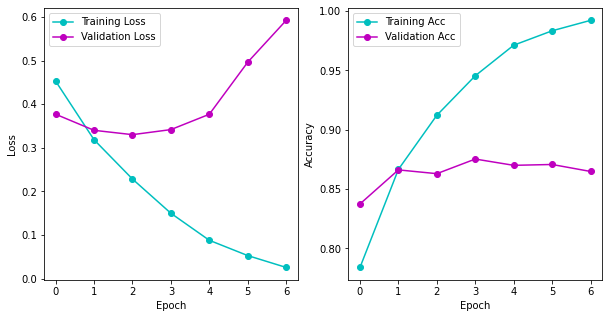

In [39]:
plot_loss_acc(metrics['train_loss'], metrics['val_loss'], metrics['train_acc'], metrics['val_acc'], epochs)

In [40]:
def get_predictions(model, iterator):
  model.eval()
  test_predictions, test_labels = [], []
  with torch.no_grad():
    for batch in iterator:
      prediction = model(batch.review[0])
      test_predictions.append(prediction)
      test_labels.append(batch.rating)
  return torch.cat(test_predictions), torch.cat(test_labels)

In [41]:
testset_path = None

if testset_path is not None:
  test_df = pandas.read_csv(dataset_path, sep='\t', engine='python')
  test_df = transform(test_df)
  test_tmp_df = copy.deepcopy(test_df)
  test_tmp_df['review'] = test_tmp_df['review'].apply(lambda x: ' '.join(x))
  test_tmp_df.drop("url", axis=1, inplace=True)
  test_tmp_df = tmp_df.reset_index(drop=True)
  test_tmp_df = tmp_df.reindex(columns=['review', 'rating'])
  test_tmp_df['review'] = tmp_df['review'].apply(str)
  test_tmp_df.to_csv("/content/drive/My Drive/preprocessed_test_df.csv", index=False)

  test_tabular_data = data.TabularDataset(
  path="/content/drive/My Drive/preprocessed_test_df.csv", format='csv', fields=[('review', review_field),
  ('rating', rating_field)],skip_header=True)

  test_it = data.BucketIterator(
    test_tabular_data, 
    batch_size = batch_size, sort_within_batch = True,
    sort_key = sort_key_fn, device = device)


In [42]:
from sklearn.metrics import classification_report

test_predictions, test_labels = get_predictions(model, test_it)

test_predictions = test_predictions.ge(.5).view(-1).cpu()
test_labels = test_labels.cpu()

print(classification_report(test_labels, test_predictions))

              precision    recall  f1-score   support

         0.0       0.88      0.85      0.87      2194
         1.0       0.87      0.89      0.88      2307

    accuracy                           0.87      4501
   macro avg       0.87      0.87      0.87      4501
weighted avg       0.87      0.87      0.87      4501



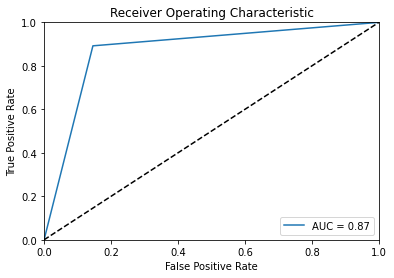

In [43]:
test_predictions = test_predictions.cpu().detach().numpy().ravel()
test_labels = test_labels.cpu().detach().numpy().ravel()
roc_auc = roc_auc_score(test_labels, test_predictions)
fpr, tpr, _ = roc_curve(test_labels, test_predictions)

plt.plot(fpr, tpr, label='AUC = {:.2f}'.format(roc_auc))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


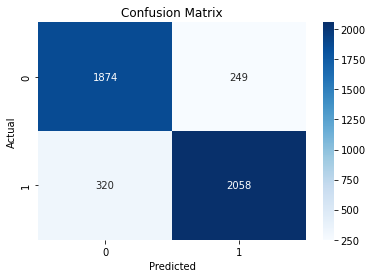

In [44]:
conf_matrix = confusion_matrix(test_predictions, test_labels.round())

sn.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()